In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
seed = 42

In [3]:
coin = 'KRW-XRP'

In [4]:
df = pd.read_csv(f'../data/from_pyupbit/{coin}.csv')

In [5]:
df

,timestamp,open,high,low,close,volume,value
0,2021-10-10 18:06:00,1470.0,1475.0,1470.0,1475.0,110563.445140,1.626721e+08
1,2021-10-10 18:07:00,1475.0,1475.0,1470.0,1470.0,360092.163153,5.293728e+08
2,2021-10-10 18:08:00,1470.0,1470.0,1465.0,1470.0,43811.266082,6.429402e+07
3,2021-10-10 18:09:00,1470.0,1470.0,1465.0,1465.0,155319.977788,2.276242e+08
4,2021-10-10 18:10:00,1465.0,1470.0,1465.0,1465.0,213592.423806,3.130284e+08
...,...,...,...,...,...,...,...
1576795,2024-10-12 21:09:00,727.2,727.3,727.1,727.2,22987.224447,1.671676e+07
1576796,2024-10-12 21:10:00,727.2,728.3,727.1,727.2,82760.592301,6.022854e+07
1576797,2024-10-12 21:11:00,727.2,728.0,727.1,727.2,47655.604030,3.465902e+07
1576798,2024-10-12 21:12:00,727.2,728.1,727.2,728.0,42141.058456,3.067595e+07


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [7]:
df

,open,high,low,close,volume,value
timestamp,,,,,,
2021-10-10 18:06:00,1470.0,1475.0,1470.0,1475.0,110563.445140,1.626721e+08
2021-10-10 18:07:00,1475.0,1475.0,1470.0,1470.0,360092.163153,5.293728e+08
2021-10-10 18:08:00,1470.0,1470.0,1465.0,1470.0,43811.266082,6.429402e+07
2021-10-10 18:09:00,1470.0,1470.0,1465.0,1465.0,155319.977788,2.276242e+08
2021-10-10 18:10:00,1465.0,1470.0,1465.0,1465.0,213592.423806,3.130284e+08
...,...,...,...,...,...,...
2024-10-12 21:09:00,727.2,727.3,727.1,727.2,22987.224447,1.671676e+07
2024-10-12 21:10:00,727.2,728.3,727.1,727.2,82760.592301,6.022854e+07
2024-10-12 21:11:00,727.2,728.0,727.1,727.2,47655.604030,3.465902e+07


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))
joblib.dump(scaler, f'models/{coin}_scaler.pkl')

['models/KRW-XRP_scaler.pkl']

In [9]:
timestep = 1

In [10]:
X = []
y = []
for i in range(len(scaled_data) - timestep - 1):
    X.append(scaled_data[i:(i + timestep), 0])
    y.append(scaled_data[i + timestep, 0])

In [11]:
X, y = np.array(X), np.array(y)

In [12]:
train_size = int(len(X) * .8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]

In [14]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
39420/39420 [==============================] - 268s 7ms/step - loss: 6.7583e-05 - val_loss: 1.2073e-06
Epoch 2/20
39420/39420 [==============================] - 182s 5ms/step - loss: 3.3757e-06 - val_loss: 1.3474e-06
Epoch 3/20
39420/39420 [==============================] - 177s 4ms/step - loss: 3.0482e-06 - val_loss: 5.4440e-07
Epoch 4/20
39420/39420 [==============================] - 182s 5ms/step - loss: 2.8863e-06 - val_loss: 7.6395e-07
Epoch 5/20
39420/39420 [==============================] - 179s 5ms/step - loss: 2.7470e-06 - val_loss: 2.3124e-06
Epoch 6/20
39420/39420 [==============================] - 177s 4ms/step - loss: 2.6411e-06 - val_loss: 5.5032e-07
Epoch 7/20
39420/39420 [==============================] - 182s 5ms/step - loss: 2.5695e-06 - val_loss: 4.6156e-07
Epoch 8/20
39420/39420 [==============================] - 181s 5ms/step - loss: 2.4965e-06 - val_loss: 6.8866e-07
Epoch 9/20
39420/39420 [==============================] - 180s 5ms/step - loss: 2.4704e-

In [19]:
model.save(f'models/lstm_{coin}.h5')

In [20]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9855/9855 [==============================] - 15s 2ms/step


In [21]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [22]:
test_predict

array([[860.8987 ],
       [861.09937],
       [860.5978 ],
       ...,
       [726.5977 ],
       [726.5977 ],
       [726.5977 ]], dtype=float32)

In [23]:
y_test

array([[861.1, 860.6, 859. , ..., 727.2, 727.2, 728. ]])

In [24]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

Train RMSE: 1.83
Test RMSE: 0.95


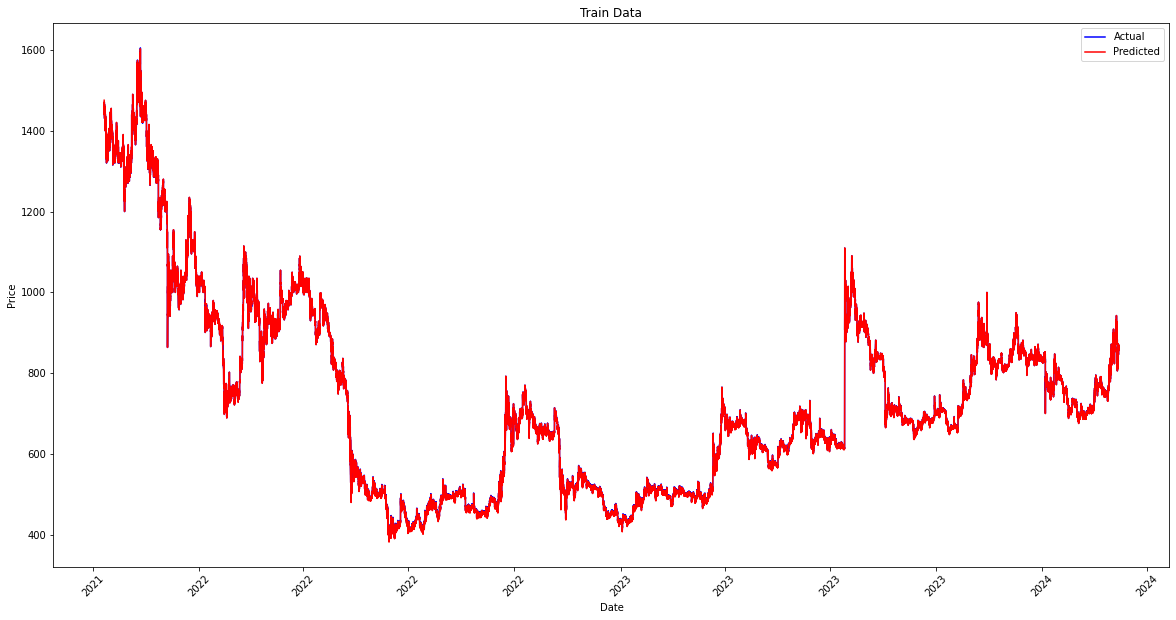

In [25]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
plt.title('Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

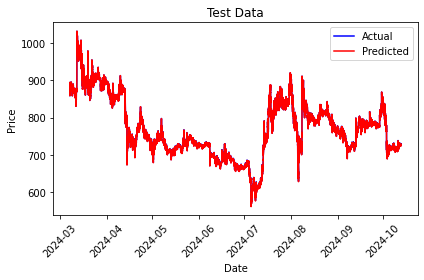

In [26]:
plt.subplot(1, 1, 1)
plt.plot(test_dates[:-2], y_test[0], label='Actual', color = 'Blue')
plt.plot(test_dates[:-2], test_predict, label='Predicted', color = 'Red')
plt.title('Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [27]:
last_1_day = scaled_data[-timestep:]
X_predict = last_1_day.reshape(1, timestep, 1)
print(last_1_day)

[[0.28106557]]


In [28]:
pred = model.predict(X_predict)
pred = scaler.inverse_transform(pred)
print(pred)

1/1 [==============================] - 0s 13ms/step
[[727.3014]]


In [29]:
preds = []
for i in range(30):
    pred = model.predict(X_predict)
    preds.append(scaler.inverse_transform(pred)[0][0])
    pred = pred.reshape(1, 1, 1)
    X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)

1/1 [==============================] - 0s 13ms/step


In [30]:
preds

[727.3014,
 726.6996,
 726.0946,
 725.4865,
 724.87524,
 724.26074,
 723.64307,
 723.0222,
 722.3981,
 721.7707,
 721.14,
 720.50604,
 719.86884,
 719.2283,
 718.58435,
 717.93713,
 717.28656,
 716.6325,
 715.97516,
 715.3144,
 714.65015,
 713.98254,
 713.31146,
 712.63684,
 711.9588,
 711.2773,
 710.5922,
 709.9037,
 709.21155,
 708.5159]